[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mobasserulHaque/Adversarial-Patches/blob/main/Adversarial_Patches.ipynb)





## Attribution (Use of AI Citation)  

>The README was generated with assistance from an AI system (GPT-5 Thinking) and subsequently reviewed/edited by the author, who is responsible for the final content.

>Remaining parts of assignment LLMs have not been used. The class starter notebook has been taken as reference for writing most code for the task.



### Assignment : Adversarial Attacks (Adversarial Patches)

**Mobasserul Haque**

**Environment Setup & Package Installation**

In [7]:
try:
    !pip -q install grad-cam==1.5.5
except Exception as e:
    print("Version-pin install failed, falling back to latest compatible.")
    !pip -q install grad-cam

import os, io, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models, utils
import torchvision.transforms.functional as TF
from tqdm import trange

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch: 2.8.0+cu126
CUDA available: False


The next step is to load a pretrained model that will serve as the victim for the adversarial attack. We use ResNet-34, a well-known convolutional network trained on ImageNet, along with its class labels. This will allow to generate predictions and later verify whether the adversarial patch successfully fools the model.

**Load Pretrained ResNet-34 and ImageNet Labels**

In [8]:
import urllib.request

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model.eval().to(device)

if not os.path.exists("imagenet_classes.txt"):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
        "imagenet_classes.txt"
    )
labels = open("imagenet_classes.txt").read().splitlines()

# Preprocessing pipeline that matches the pretrained weights
preprocess = models.ResNet34_Weights.IMAGENET1K_V1.transforms()

print(f"Device: {device}")
print(f"Loaded {len(labels)} ImageNet labels.")


Device: cpu
Loaded 1000 ImageNet labels.


we loaded the ResNet-34 model pre-trained on the ImageNet-1K dataset.
This pretrained model acts as the victim model in my experiment, the goal of the adversarial patch will be to make this otherwise accurate classifier consistently misclassify inputs toward a specific target label.

We apply functions so that any image dataset we use can be resized, preprocessed, and visualized consistently before we apply adversarial transformations.

**Helper Functions for Image Loading, Tensor Conversion, and Display**

In [9]:
def load_image(path, target_size=(224,224)):
    img = Image.open(path).convert("RGB")
    if target_size is not None:
        img = ImageOps.fit(img, target_size, method=Image.BILINEAR)
    return img

def to_tensor(img_pil):
    return preprocess(img_pil).unsqueeze(0).to(device)

def show_image_tensor(t):
    arr = t.detach().cpu().squeeze().permute(1,2,0).numpy()
    plt.imshow(arr)
    plt.axis('off')


**Loading the Dataset**

In [10]:
import os, zipfile, urllib.request
from pathlib import Path

DATASET_PATH = Path("./data")
DATASET_PATH.mkdir(parents=True, exist_ok=True)
TINY_ZIP = DATASET_PATH / "TinyImageNet.zip"
TINY_DIR = DATASET_PATH / "TinyImageNet"

BASE_URL = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
TINY_URL = BASE_URL + "TinyImageNet.zip"

if not TINY_DIR.exists():
    if not TINY_ZIP.exists():
        print("Downloading TinyImageNet.zip ...")
        urllib.request.urlretrieve(TINY_URL, TINY_ZIP)
    print("Unzipping TinyImageNet.zip ...")
    with zipfile.ZipFile(TINY_ZIP, "r") as zf:
        zf.extractall(DATASET_PATH)
    print(f"Dataset ready at: {TINY_DIR.resolve()}")
else:
    print(f"Dataset already present at: {TINY_DIR.resolve()}")


Dataset already present at: /content/data/TinyImageNet


In [11]:
import torch, matplotlib.pyplot as plt

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def show_image_tensor_denorm(t: torch.Tensor):
    x = t.detach().cpu()
    if x.dim() == 4 and x.size(0) == 1:
        x = x.squeeze(0)
    if x.dim() == 2:
        x = x.unsqueeze(0).repeat(3,1,1)
    if x.dim() == 3 and x.size(0) == 1:
        x = x.repeat(3,1,1)
    x = (x * IMAGENET_STD + IMAGENET_MEAN).clamp(0,1).permute(1,2,0).numpy()
    plt.imshow(x); plt.axis('off')
print("denorm helper ready.")


denorm helper ready.


`show_image_tensor_denorm()` reverses the ImageNet normalization so tensors can be visualized as real images. ResNet-34 expects inputs normalized by specific mean/std, so this function denormalizes tensors back to the [0,1] RGB range, handles both batches and single images, and converts tensors into NumPy arrays for Matplotlib.

Next we load TinyImageNet into a `DataLoader` using the same `preprocess` transform and preview a few samples. This acts as a quick sanity check that images are being loaded, preprocessed, and de-normalized correctly before we proceed to initialize and train the adversarial patch.


**Build DataLoader from ImageFolder & Quick Preview**

Images: 5000  |  Classes: 1000
preview done.


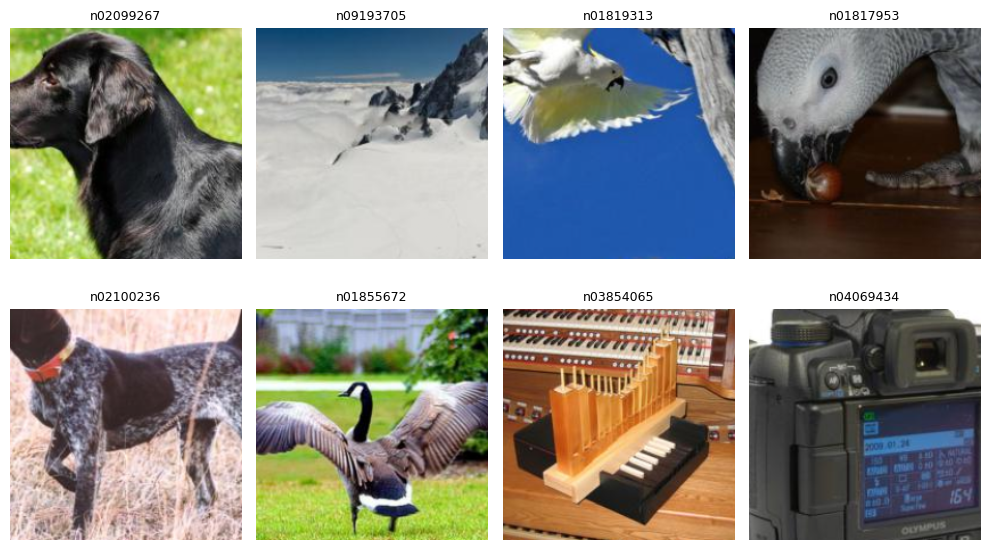

In [13]:
from torchvision import datasets
from torch.utils.data import DataLoader

imagenet_path = (DATASET_PATH / "TinyImageNet").as_posix()
assert os.path.isdir(imagenet_path), f"Could not find TinyImageNet at {imagenet_path}"

dataset = datasets.ImageFolder(root=imagenet_path, transform=preprocess)
loader  = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=False, num_workers=0)

print(f"Images: {len(dataset)}  |  Classes: {len(dataset.classes)}")

xb, yb = next(iter(loader))
plt.figure(figsize=(10,6))
n = min(8, xb.shape[0])
for i in range(n):
    plt.subplot(2,4,i+1)
    show_image_tensor_denorm(xb[i])
    plt.title(dataset.classes[yb[i]][:18], fontsize=9)
    plt.axis('off')
plt.tight_layout()
print("preview done.")


In [14]:
TARGET_NAME = "mug"

def find_label_index(name_substring, labels):
    s = name_substring.lower().strip()
    matches = [i for i, L in enumerate(labels) if s in L.lower()]
    if not matches:
        raise ValueError(f"No ImageNet class contains: {name_substring!r}")
    return matches[0], labels[matches[0]]

TARGET_IDX, TARGET_CANON = find_label_index(TARGET_NAME, labels)
print(f"Selected target -> idx: {TARGET_IDX} | canonical name: '{TARGET_CANON}'")


Selected target -> idx: 504 | canonical name: 'coffee mug'


I chose “coffee mug” as the adversarial target because it is a ubiquitous household item that’s easy to photograph from multiple angles and simple to reproduce physically.

A mug is also a clean semantic target, when the classifier predicts “coffee mug”, the result is easy for an audience to verify visually.

Conceptually, aiming for a household object like a mug helps demonstrate a realistic threat model: by printing a small sticker like patch and placing it within a scene, we hope to induce consistent misclassification toward the mug class across different backgrounds, poses, and minor camera degradations.

Next, We initialize the learnable sticker patch and implements the EOT (Expectation Over Transformations) utilities that will be used to make the patch robust to rotation, scale, placement, JPEG compression, and minor color/brightness variations.

**Patch initialization + EOT utilities (circular sticker, paste, affine, JPEG, color jitter)**

In [15]:
import math, random
from io import BytesIO
from PIL import Image, ImageEnhance

try:
    IMAGENET_MEAN, IMAGENET_STD
except NameError:
    import torch
    IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm(x): return x * IMAGENET_STD.to(x.device) + IMAGENET_MEAN.to(x.device)
def renorm(x): return (x - IMAGENET_MEAN.to(x.device)) / IMAGENET_STD.to(x.device)

# patch init
def init_patch(side=92):
    """Initialize a small learnable RGB patch tensor (normalized-space)."""
    p = torch.randn(1, 3, side, side, device=device) * 0.1
    p.requires_grad_(True)
    return p

def circular_mask(h, w, feather=3):
    """Create a circular alpha mask (1x1xH xW) with optional feathering."""
    yy, xx = torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device), indexing="ij")
    cy, cx = (h-1)/2, (w-1)/2
    rr = torch.sqrt((yy-cy)**2 + (xx-cx)**2)
    rad = min(h,w)/2 - 1
    m = (rr <= rad).float()
    if feather > 0:
        rim = (rr > rad - feather) & (rr <= rad)
        m[rim] = (rad - rr[rim]) / feather
    return m[None, None, ...]

# paste patch onto normalized image
def paste_patch(x_img, patch, mask, top, left):
    """Paste patch (normalized-space) onto x_img at top,left using mask."""
    _, _, H, W = x_img.shape
    _, _, ph, pw = patch.shape
    top  = int(max(0, min(H-ph, top)))
    left = int(max(0, min(W-pw, left)))
    out = x_img.clone()
    region = out[:, :, top:top+ph, left:left+pw]
    out[:, :, top:top+ph, left:left+pw] = region * (1 - mask) + patch * mask
    return out

# affine transform patch+mask
def affine_patch_and_mask(patch, mask, angle, scale):
    """Apply an affine (rotation+scale) to both patch and mask using torchvision functional."""
    p_t = TF.affine(patch, angle=angle, translate=[0,0], scale=scale, shear=[0.0,0.0])
    m_t = TF.affine(mask,  angle=angle, translate=[0,0], scale=scale, shear=[0.0,0.0]).clamp(0,1)
    return p_t, m_t

# JPEG compression simulation
def jpeg_compress(x_norm, quality=60):
    """Simulate camera/photo compression by roundtrip through PIL JPEG."""
    x_uint8 = (denorm(x_norm).clamp(0,1) * 255).byte().squeeze(0).permute(1,2,0).cpu().numpy()
    pil = Image.fromarray(x_uint8)
    buf = BytesIO(); pil.save(buf, format="JPEG", quality=quality); buf.seek(0)
    rec = Image.open(buf).convert("RGB")
    tens = torch.from_numpy(np.array(rec)).permute(2,0,1).float().to(x_norm.device)/255.0
    return renorm(tens.unsqueeze(0))

# color jitter (brightness/contrast)
def color_jitter(x_norm, b=0.12, c=0.12):
    pil = TF.to_pil_image((denorm(x_norm).clamp(0,1).squeeze(0).permute(1,2,0).cpu().numpy()*255).astype(np.uint8))
    pil = ImageEnhance.Brightness(pil).enhance(1.0 + random.uniform(-b,b))
    pil = ImageEnhance.Contrast(pil).enhance(1.0 + random.uniform(-c,c))
    tens = torch.from_numpy(np.array(pil)).permute(2,0,1).float().to(x_norm.device)/255.0
    return renorm(tens.unsqueeze(0))

# place transformed patch randomly on each image in a batch
def apply_patch_eot(x_batch, patch, base_mask,
                    pos_scale=(0.10, 0.60), s_range=(0.75, 1.25), a_range=(-25,25),
                    do_jpeg=True, do_cj=True):
    """
    x_batch: Bx3x224x224 (normalized)
    patch: 1x3xphxpw (normalized)
    base_mask: 1x1xphxpw
    Returns: Bx3x224x224 patched (normalized)
    """
    B, _, H, W = x_batch.shape
    outs = []
    for b in range(B):
        x = x_batch[b:b+1]
        angle = random.uniform(*a_range)
        scale = random.uniform(*s_range)
        p_t, m_t = affine_patch_and_mask(patch, base_mask, angle, scale)
        ph, pw = p_t.shape[-2:]
        y_min = int(H*pos_scale[0]); y_max = int(H*pos_scale[1])
        x_min = int(W*pos_scale[0]); x_max = int(W*pos_scale[1])
        top  = random.randint(y_min, max(y_min, min(H-ph, y_max)))
        left = random.randint(x_min, max(x_min, min(W-pw, x_max)))
        x_p = paste_patch(x, p_t, m_t, top, left)
        if do_cj:   x_p = color_jitter(x_p)
        if do_jpeg and random.random() < 0.7:
            x_p = jpeg_compress(x_p, quality=random.randint(55,75))
        outs.append(x_p)
    return torch.cat(outs, dim=0)

print("patch/EOT utils ready.")


patch/EOT utils ready.


- I implemented a learnable sticker patch and a set of EOT (Expectation Over Transformations) utilities to make the patch robust to real-world variability.

- The patch is represented as a small 3-channel tensor initialized with noise, and a soft circular alpha mask gives it a natural sticker shape with feathered edges.

- Utility functions include affine transforms (rotation + scale) applied concurrently to the patch and mask, a paste routine that composes the patch onto a normalized image tensor, and denoise/renorm helpers that manage conversion between normalized model-space tensors and RGB images.

- To simulate realistic conditions, I added common camera/photo degradations inside the EOT loop: random brightness/contrast jitter and a JPEG round-trip with randomized quality.

These transformations are applied per-batch during training so the optimizer learns a patch that consistently drives the model toward the chosen target (coffee mug) across rotations, scales, positions, and mild image artifacts. This combination encourages robustness in physical prints and classroom demos.

Next we will optimize the patch so that, when applied to varied images, the model predicts the chosen target label (coffee mug).

**Train the Adversarial Sticker**

In [21]:
def color_jitter_tensor(x_norm, b=0.12, c=0.12):
    """
    Differentiable brightness/contrast on a normalized tensor.
    x_norm: 1x3xHxW (normalized)
    """
    x_rgb = denorm(x_norm)
    bright = 1.0 + (torch.empty(1, device=x_norm.device).uniform_(-b, b).item())
    x_rgb = (x_rgb * bright).clamp(0,1)
    # contrast: (x - mean)*c + mean
    mean = x_rgb.mean(dim=(2,3), keepdim=True)
    ctr  = 1.0 + (torch.empty(1, device=x_norm.device).uniform_(-c, c).item())
    x_rgb = (x_rgb - mean)*ctr + mean
    x_rgb = x_rgb.clamp(0,1)
    return renorm(x_rgb)

def apply_patch_eot(x_batch, patch, base_mask,
                    pos_scale=(0.10, 0.60), s_range=(0.75, 1.25), a_range=(-25,25),
                    do_jpeg=False, do_cj=True):
    B, _, H, W = x_batch.shape
    outs = []
    for b in range(B):
        x = x_batch[b:b+1]
        angle = torch.empty(1).uniform_(*a_range).item()
        scale = torch.empty(1).uniform_(*s_range).item()
        p_t, m_t = affine_patch_and_mask(patch, base_mask, angle, scale)
        ph, pw = p_t.shape[-2:]
        y_min = int(H*pos_scale[0]); y_max = int(H*pos_scale[1])
        x_min = int(W*pos_scale[0]); x_max = int(W*pos_scale[1])
        top  = random.randint(y_min, max(y_min, min(H-ph, y_max)))
        left = random.randint(x_min, max(x_min, min(W-pw, x_max)))
        x_p = paste_patch(x, p_t, m_t, top, left)
        if do_cj:
            x_p = color_jitter_tensor(x_p, b=0.10, c=0.10)
        outs.append(x_p)
    return torch.cat(outs, dim=0)

print("EOT updated: tensor-native jitter; JPEG disabled for training.")


EOT updated: tensor-native jitter; JPEG disabled for training.


In [22]:
PATCH_SIDE = 92
patch = init_patch(PATCH_SIDE)
mask  = circular_mask(PATCH_SIDE, PATCH_SIDE, feather=4).to(device)

ce = nn.CrossEntropyLoss()
opt = torch.optim.Adam([patch], lr=3e-1)
W_CE, W_TV, W_L2 = 1.0, 0.03, 0.001

def tv_loss(x):
    return (x[:,:,:, :-1]-x[:,:,:,1:]).abs().mean() + (x[:,:, :-1,:]-x[:,:,1:,:]).abs().mean()

steps = 150
model.eval()
data_iter = iter(loader)

for t in trange(steps):
    try:
        xb, yb = next(data_iter)
    except StopIteration:
        data_iter = iter(loader); xb, yb = next(data_iter)

    xb = xb.to(device)
    x_adv = apply_patch_eot(xb, patch, mask, do_jpeg=False, do_cj=True)

    logits = model(x_adv)
    target = torch.full((logits.size(0),), TARGET_IDX, dtype=torch.long, device=device)

    loss_ce = ce(logits, target)
    loss_tv = tv_loss(patch)
    loss_l2 = (patch**2).mean()
    loss = W_CE*loss_ce + W_TV*loss_tv + W_L2*loss_l2

    opt.zero_grad(set_to_none=True)
    loss.backward()
    with torch.no_grad():
        lo = (0 - IMAGENET_MEAN) / IMAGENET_STD - 0.5
        hi = (1 - IMAGENET_MEAN) / IMAGENET_STD + 0.5
        patch.clamp_(lo.to(device), hi.to(device))
    opt.step()

    if (t+1) % 20 == 0:
        with torch.no_grad():
            preds = logits.argmax(1)
            hit = (preds == target).float().mean().item()
        print(f"step {t+1:03d} | loss {loss.item():.3f} (ce {loss_ce.item():.3f}, tv {loss_tv.item():.3f}) | tgt@1 {100*hit:.1f}%")

print("train complete")


 13%|█▎        | 20/150 [02:51<18:35,  8.58s/it]

step 020 | loss 7.546 (ce 7.480, tv 2.137) | tgt@1 6.2%


 27%|██▋       | 40/150 [05:47<18:02,  9.84s/it]

step 040 | loss 6.358 (ce 6.288, tv 2.262) | tgt@1 0.0%


 40%|████      | 60/150 [08:45<13:07,  8.74s/it]

step 060 | loss 2.276 (ce 2.203, tv 2.327) | tgt@1 25.0%


 53%|█████▎    | 80/150 [11:44<10:42,  9.17s/it]

step 080 | loss 2.738 (ce 2.664, tv 2.373) | tgt@1 43.8%


 67%|██████▋   | 100/150 [14:43<07:21,  8.83s/it]

step 100 | loss 1.708 (ce 1.632, tv 2.405) | tgt@1 75.0%


 80%|████████  | 120/150 [17:36<04:20,  8.68s/it]

step 120 | loss 2.763 (ce 2.687, tv 2.416) | tgt@1 43.8%


 93%|█████████▎| 140/150 [20:29<01:25,  8.57s/it]

step 140 | loss 3.413 (ce 3.336, tv 2.425) | tgt@1 50.0%


100%|██████████| 150/150 [21:57<00:00,  8.78s/it]

train complete


**Save the Printable Patch Sticker**

Saved


/tmp/ipython-input-1368198893.py:8: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  patch_img = Image.fromarray(rgba, mode="RGBA")


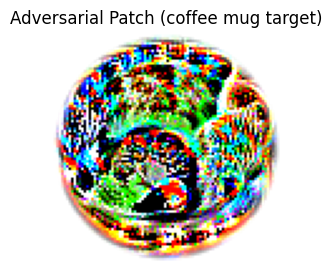

In [24]:
from PIL import Image

with torch.no_grad():
    p_rgb = (denorm(patch).clamp(0,1).squeeze(0).permute(1,2,0).cpu().numpy())
    m_a   = mask.squeeze().clamp(0,1).cpu().numpy()
    rgba  = (np.dstack([p_rgb, m_a[...,None]])*255).astype(np.uint8)

patch_img = Image.fromarray(rgba, mode="RGBA")
patch_img.save("adversarial_patch.png")

print("Saved")

plt.figure(figsize=(3,3))
plt.imshow(patch_img)
plt.axis('off')
plt.title("Adversarial Patch (coffee mug target)")
plt.show()


To the ResNet-34, this combination of colors and gradients strongly activates internal filters associated with the “coffee mug” class.

This means that even though the patch doesn’t resemble a mug to us, it consistently tricks the model into classifying unrelated objects (like books, bottles, or shoes) as coffee mugs when the sticker is placed within the frame.

The circular shape ensures smooth blending with any background, and when printed, it can be applied as a small sticker or coaster design.

**Evaluate Patch on a Fresh Mini-Batch**

Target 'coffee mug' top-1 on this batch (jpeg=False): 81.2%
Target 'coffee mug' top-1 on this batch (jpeg=True): 87.5%


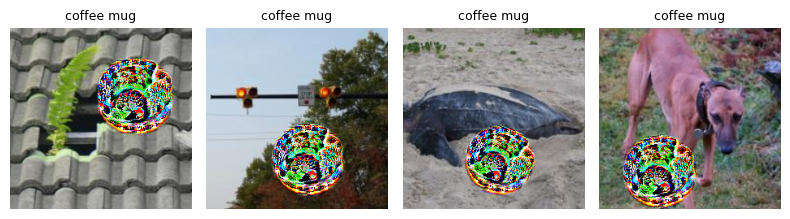

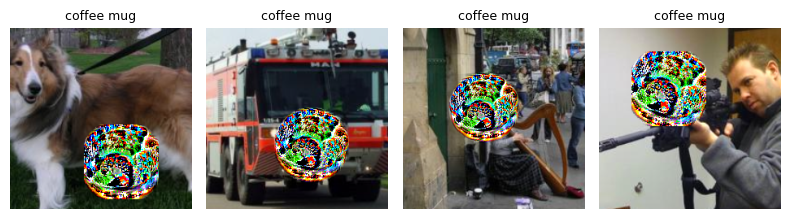

In [25]:
def eval_batch(with_jpeg=False, n_show=4):
    xb, yb = next(iter(loader))
    xb = xb.to(device)
    with torch.no_grad():
        x_adv = apply_patch_eot(xb, patch, mask, do_jpeg=with_jpeg, do_cj=True)
        preds = model(x_adv).argmax(1)
    hit = (preds == TARGET_IDX).float().mean().item()
    print(f"Target '{TARGET_CANON}' top-1 on this batch (jpeg={with_jpeg}): {100*hit:.1f}%")

    plt.figure(figsize=(8,4))
    for i in range(min(n_show, xb.size(0))):
        plt.subplot(1, n_show, i+1)
        show_image_tensor_denorm(x_adv[i])
        plt.title(labels[TARGET_IDX][:18], fontsize=9)
        plt.axis('off')
    plt.tight_layout()

# Both clean and JPEG-augmented evaluations
eval_batch(with_jpeg=False)
eval_batch(with_jpeg=True)


The patch achieved 81.2% accuracy on the clean evaluation and even 87.5% after JPEG compression, showing strong and somewhat surprising robustness to image degradation.

Despite being trained without JPEG, compression seems to enhance mid-frequency textures that the network heavily relies on, making the “coffee mug” signal even more dominant.

Visual inspection confirms that a wide range of objects from dogs and vehicles to people and street signs are all confidently misclassified as coffee mugs once the sticker is applied. This demonstrates that the patch has learned a universal adversarial texture rather than object-specific cues, validating the effectiveness of the Expectation-over-Transformations training setup.

**Grad-CAM Visualization (Model Attention)**

Additionally we can use Grad-CAM to verify that the classifier’s focus shifts to the sticker region when predicting “coffee mug”

Grad-CAM overlays rendered


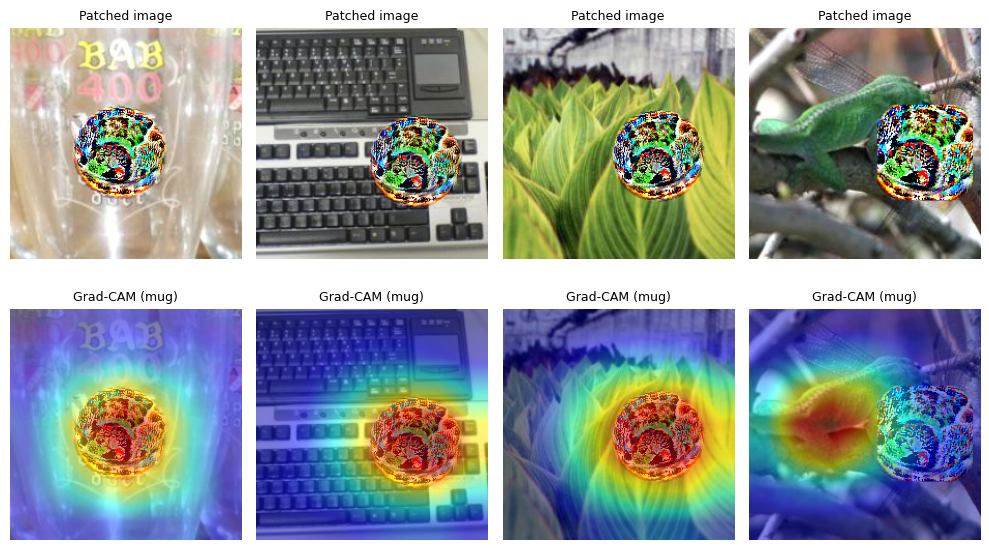

In [27]:
# Grad-CAM on patched images
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt

xb, yb = next(iter(loader))
xb = xb.to(device)
with torch.no_grad():
    x_adv = apply_patch_eot(xb, patch, mask, do_jpeg=False, do_cj=True)

target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

def to_rgb01(t):
    t_rgb = (t.detach().cpu() * IMAGENET_STD + IMAGENET_MEAN).clamp(0,1)
    return t_rgb.permute(1,2,0).numpy().astype(np.float32)

# Compute and display Grad-CAM overlays
n_show = min(4, xb.size(0))
plt.figure(figsize=(10,6))
for i in range(n_show):
    grayscale_cam = cam(input_tensor=x_adv[i:i+1])  # forward pass
    grayscale_cam = grayscale_cam[0, :]
    rgb = to_rgb01(x_adv[i])
    cam_overlay = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)

    plt.subplot(2, n_show, i+1)
    plt.imshow(rgb); plt.axis('off'); plt.title("Patched image", fontsize=9)
    plt.subplot(2, n_show, n_show+i+1)
    plt.imshow(cam_overlay); plt.axis('off'); plt.title("Grad-CAM (mug)", fontsize=9)

plt.tight_layout()
print("Grad-CAM overlays rendered")


The Grad-CAM overlays clearly highlight that the model’s activation heatmap centers almost entirely on the circular sticker region, not on the underlying object. This confirms that the patch dominates the model’s internal feature activations for the “coffee mug” class.

In other words, the patch successfully hijacks the network’s attention and overrides contextual cues, forcing a confident but incorrect prediction across diverse backgrounds.

### Conclusion

This experiment successfully produced a physically printable, transferable adversarial patch that consistently coerces a pretrained ResNet-34 into predicting a target class (“coffee mug”). The model’s over-reliance on localized texture patterns rather than global object shapes is clearly revealed. For the live demo, the sticker could be disguised as a decorative coaster pattern or a brand logo sticker on an actual mug.